There is a lot more that you can do with outputs (such as including interactive outputs)
with your book. For more information about this, see [the Jupyter Book documentation](https://jupyterbook.org)


# Обработка информации об уязвимостях полученных из CVE Project (https://github.com/CVEProject/cvelistV5)


In [26]:
from concurrent.futures import ThreadPoolExecutor
import httpx
import zipfile
import tempfile
from pathlib import Path
import orjson as ojson
from typing import Any
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from const import CVE_PROJECT_CVES_DATA_PATH
import re

## Скачивание данных


In [18]:
CVE_ZIP_URL = "https://github.com/CVEProject/cvelistV5/releases/download/cve_2024-01-05_1500Z/2024-01-05_all_CVEs_at_midnight.zip.zip"
# Download archive
resp = httpx.get(CVE_ZIP_URL, follow_redirects=True)

with tempfile.TemporaryDirectory() as tmpdir:
    tmp_path = Path(tmpdir)

    with (tmp_path / "cve.zip.zip").open("wb") as f:
        f.write(resp.content)

    with zipfile.ZipFile(f.name, "r") as zip_ref:
        tmp_zip = tmp_path / "cves.zip"
        zip_ref.extractall(tmp_path)
        with zipfile.ZipFile(tmp_zip) as zip_ref:
            files_to_extract = [
                name
                for name in zip_ref.namelist()
                if name.startswith(tuple(f"cves/{year}/" for year in range(2013, 2023)))
            ]
            zip_ref.extractall(members=files_to_extract)

In [19]:
cves_data: list[dict[str, Any]] = []
cves_folder = Path("cves/")
with ThreadPoolExecutor(20) as p:
    filename: str
    for filename, content in p.map(lambda fp: (fp.name, fp.read_text()), cves_folder.rglob("202*/**/*.json")):
        data = ojson.loads(content)
        data["cve_id"] = filename[4:-5]
        data["year"] = filename[4:-9]
        cves_data.append(data)

len(cves_data)

88692

In [5]:
CWE_ZIP_URL = "https://cwe.mitre.org/data/csv/1000.csv.zip"
# Download archive
resp = httpx.get(CWE_ZIP_URL, follow_redirects=True)

with tempfile.TemporaryDirectory() as tmpdir:
    tmp_path = Path(tmpdir)

    with (tmp_path / "cwe.zip").open("wb") as f:
        f.write(resp.content)

    with zipfile.ZipFile(f.name, "r") as zip_ref:
        cwes_folder = Path("cwes/")
        cwes_folder.mkdir(exist_ok=True)
        zip_ref.extractall(cwes_folder)

In [5]:
cwes = pl.read_csv("cwes/1000.csv", truncate_ragged_lines=True)
cwes.head()

CWE-ID,Name,Weakness Abstraction,Status,Description,Extended Description,Related Weaknesses,Weakness Ordinalities,Applicable Platforms,Background Details,Alternate Terms,Modes Of Introduction,Exploitation Factors,Likelihood of Exploit,Common Consequences,Detection Methods,Potential Mitigations,Observed Examples,Functional Areas,Affected Resources,Taxonomy Mappings,Related Attack Patterns,Notes
i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
5,"""J2EE Misconfig…","""Variant""","""Draft""","""Information se…","""""","""::NATURE:Child…","""""","""::LANGUAGE NAM…","""""","""""","""::PHASE:Implem…","""""",null,"""::SCOPE:Confid…","""""","""::PHASE:System…","""""",null,null,"""::TAXONOMY NAM…",null,"""::TYPE:Other:N…"
6,"""J2EE Misconfig…","""Variant""","""Incomplete""","""The J2EE appli…","""If an attacker…","""::NATURE:Child…","""""","""::LANGUAGE NAM…","""::Session ID's…","""""","""::PHASE:Archit…","""""",null,"""::SCOPE:Access…","""""","""::PHASE:Implem…","""""",null,null,"""::TAXONOMY NAM…","""::21::59::""",""""""
7,"""J2EE Misconfig…","""Variant""","""Incomplete""","""The default er…","""A Web applicat…","""::NATURE:Child…","""""","""::LANGUAGE NAM…","""""","""""","""::PHASE:Implem…","""""",null,"""::SCOPE:Confid…","""""","""::PHASE:Implem…","""""",null,null,"""::TAXONOMY NAM…",null,""""""
8,"""J2EE Misconfig…","""Variant""","""Incomplete""","""When an applic…","""""","""::NATURE:Child…","""""",null,"""""","""""","""::PHASE:Archit…","""""",null,"""::SCOPE:Confid…","""""","""::PHASE:Implem…","""""",null,null,"""::TAXONOMY NAM…",null,"""::TYPE:Other:N…"
9,"""J2EE Misconfig…","""Variant""","""Draft""","""If elevated ac…","""If the EJB dep…","""::NATURE:Child…","""""",null,"""""","""""","""::PHASE:Archit…","""""",null,"""::SCOPE:Other:…","""""","""::PHASE:Archit…","""""",null,null,"""::TAXONOMY NAM…",null,""""""


## Парсинг и обработка данных

In [37]:
from collections import Counter


Counter(cwe_description for cve in cves_data for problem_Type in cve["containers"]["cna"].get("problemTypes", []) for cwe_description in problem_type["descriptions"] if cwe_description.get("type") == "CWE" and cwe_description.get("cweId") == None)

Counter({'descriptions': 3756, 'capecId': 3576})

In [44]:
[impact for cve in cves_data for impact in cve["containers"]["cna"].get("impacts", []) if impact.get("capecId") == None]

[{'descriptions': [{'lang': 'en',
    'value': 'By sending specific queries to the resolver, an attacker can cause `named` to crash.'}]},
 {'descriptions': [{'lang': 'en',
    'value': 'An attacker controlling a malicious nameserver could respond with two responses in quick succession, each with a "CLIENT-SUBNET" pseudo-option and where the first is broken. Processing the second response after the first causes named to terminate.\n\nAll affected versions of the BIND Supported Preview Edition are vulnerable, including those that are not configured to use ECS.'}]},
 {'descriptions': [{'lang': 'en',
    'value': 'By flooding the target server with UPDATE requests, the attacker can exhaust all available memory on that server.'}]},
 {'descriptions': [{'lang': 'en',
    'value': 'By sending specific queries to the resolver, an attacker can cause `named` to crash.'}]},
 {'descriptions': [{'lang': 'en', 'value': 'Denial of Service'}]},
 {'descriptions': [{'lang': 'en', 'value': 'Denial of Serv

In [56]:
vulnerabilities_data: list[dict[str, str | float | None]] = []
for cve in cves_data:
    cve_data = {"cve_id": cve["cve_id"], "year": cve["year"]}
    cna_cve = cve["containers"]["cna"]

    # CWE data parsing
    cve_data["cwe_id"] = []
    cve_data["cwe_description"] = []
    for problem_type in cna_cve.get("problemTypes", []):
        other_cwe_descriptions = []
        has_cwe_id = False
        for cwe_description in problem_type["descriptions"]:
            problem_type = cwe_description.get("type")
            if problem_type == "CWE" and (cwe_id := cwe_description.get("cweId")):
                has_cwe_id = True
                cve_data["cwe_id"].append(cwe_id)
            elif problem_type == "text" or problem_type == "Impact" or problem_type == None:
                if re.search(r"CWE-\d+", cwe_description["description"]):
                    cve_data["cwe_id"].append(re.search(r"CWE-\d+", cwe_description["description"]).group())
                    has_cwe_id = True
                else:
                    other_cwe_descriptions.append(cwe_description["description"])
        if not has_cwe_id:
            cve_data["cwe_description"] = other_cwe_descriptions

    # score metrics parsing
    if metrics := cna_cve.get("metrics"):
        for metric in metrics:
            score_v3_1 = metric.get("cvssV3_1", {}).get("baseScore")
            cve_data["cvss_v31"] = float(score_v3_1) if score_v3_1 else None
            score_v3_1 = metric.get("cvssV3_0", {}).get("baseScore")
            cve_data["cvss_v30"] = float(score_v3_1) if score_v3_1 else None

    # references parsing
    references: list[str] = []
    for reference in cna_cve.get("references", []):
        if url := reference["url"]:
            references.append(url)
    cve_data["references"] = references

    # Source parsing
    cve_data["discovery"] = cna_cve.get("source", {}).get("discovery", "UNKNOWN")

    # description processing
    cve_data["cve_description"] = [
        description["value"] for description in cna_cve.get("descriptions", []) if "value" in description
    ]

    # Capec and attack vector parsing
    cve_data["capec_id"] = [capec["capecId"] for capec in cna_cve.get("impacts", []) if "capecId" in capec]
    cve_data["attack_description"] = [
        description_impact["value"]
        for impact in cna_cve.get("impacts", [])
        if "capecId" not in impact
        for description_impact in impact["descriptions"]
    ]

    # Affected list
    cve_data["affected_product"] = [
        affected["product"] for affected in cna_cve.get("affected", []) if "product" in affected
    ]

    vulnerabilities_data.append(cve_data)

vulnerabilities: pl.DataFrame = pl.from_dicts(vulnerabilities_data)
vulnerabilities = vulnerabilities.explode("cwe_id").explode("cwe_description").explode("references").explode("cve_description").explode("capec_id").explode("attack_description").explode("affected_product")
vulnerabilities.describe()

describe,cve_id,year,cwe_id,cwe_description,cvss_v31,cvss_v30,references,discovery,cve_description,capec_id,attack_description,affected_product
str,str,str,str,str,f64,f64,str,str,str,str,str,str
"""count""","""312533""","""312533""","""312533""","""312533""",312533.0,312533.0,"""312533""","""312533""","""312533""","""312533""","""312533""","""312533"""
"""null_count""","""0""","""0""","""193782""","""128179""",176321.0,297078.0,"""3380""","""0""","""3380""","""306333""","""307874""","""3390"""
"""mean""",null,null,null,null,6.908265,6.56022,null,null,null,null,null,null
"""std""",null,null,null,null,1.60563,1.814146,null,null,null,null,null,null
"""min""","""2020-0001""","""2020-""","""CWE-020""",""" """,1.6,2.0,"""ftp://ftp.ifax…","""""",""" …","""CAPEC-1""",""" """,""" Dell Trusted …"
"""25%""",null,null,null,null,5.5,5.3,null,null,null,null,null,null
"""50%""",null,null,null,null,7.5,6.5,null,null,null,null,null,null
"""75%""",null,null,null,null,7.8,7.8,null,null,null,null,null,null
"""max""","""2023-6622""","""2023-5""","""CWE-99""","""xforms submiss…",10.0,10.0,"""ttps://www.clo…","""external""","""“Shuup” applic…","""CAPEC-98""","""code execution…","""코드엠샵 마이사이트 – M…"


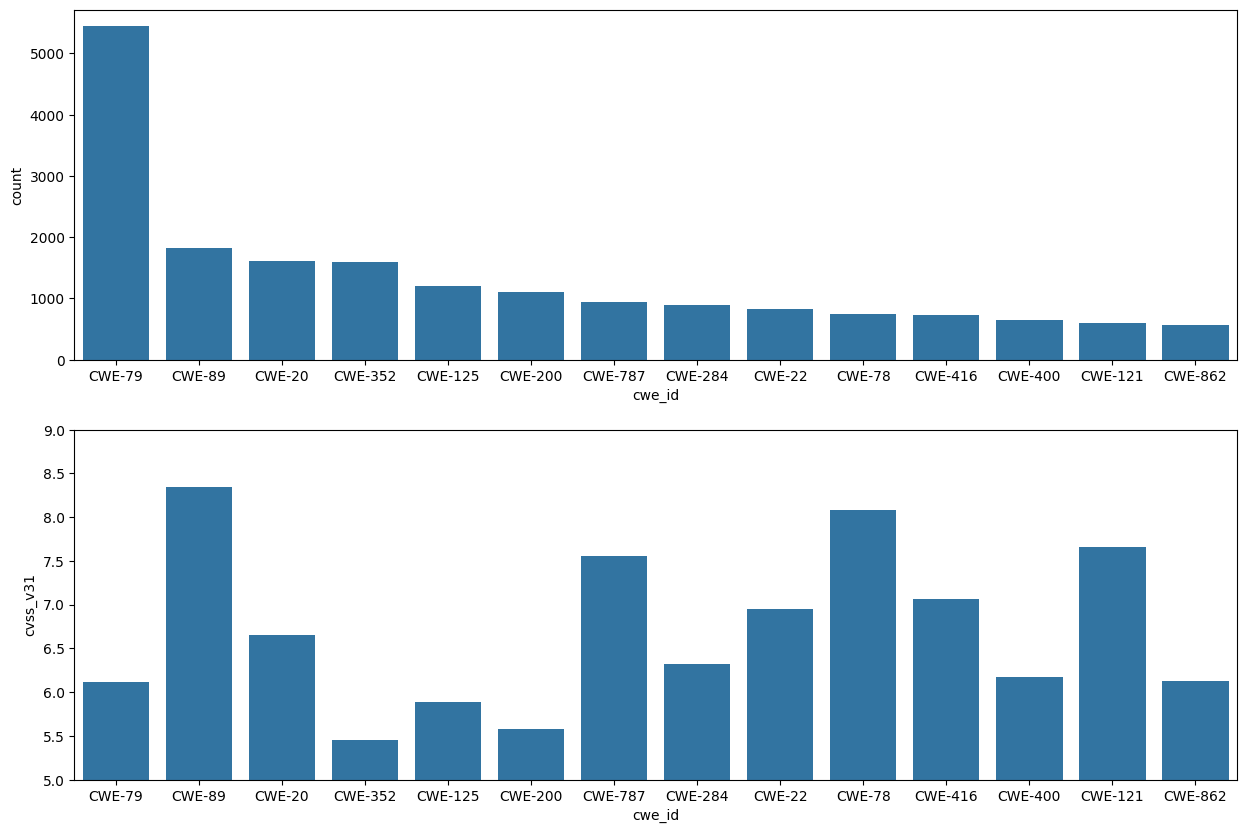

In [65]:
fig, ax = plt.subplots(2, figsize=(15, 10))
top_vulnerabilities = vulnerabilities.unique(["cve_id", "cwe_id"]).group_by("cwe_id").count().sort("count", descending=True).limit(15)
top_ids = top_vulnerabilities.select("cwe_id").to_series().to_list()
ax[1].set_ylim(5, 9)
sns.barplot(top_vulnerabilities, x="cwe_id", y="count", ax=ax[0])
sns.barplot(
    top_vulnerabilities.select("cwe_id").join(
        vulnerabilities.unique(["cve_id", "cwe_id"]).select(["cwe_id", "cvss_v31"]).filter(pl.col("cwe_id").is_in(top_ids)).group_by("cwe_id").mean(), on="cwe_id", how="left"
    ),
    x="cwe_id",
    y="cvss_v31",
    ax=ax[1],
)
plt.show()

In [66]:
with pl.Config(fmt_str_lengths=200, tbl_width_chars=150, tbl_rows=20):
    print(
        top_vulnerabilities.select(pl.col("cwe_id").str.slice(4).cast(pl.Int64)).join(
            cwes.rename({"CWE-ID": "cwe_id"}).select(["cwe_id", "Name", "Description"]), on="cwe_id"
        )
    )

shape: (14, 3)
┌────────┬─────────────────────────────────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────┐
│ cwe_id ┆ Name                                                                ┆ Description                                                         │
│ ---    ┆ ---                                                                 ┆ ---                                                                 │
│ i64    ┆ str                                                                 ┆ str                                                                 │
╞════════╪═════════════════════════════════════════════════════════════════════╪═════════════════════════════════════════════════════════════════════╡
│ 20     ┆ Improper Input Validation                                           ┆ The product receives input or data, but it does not validate or     │
│        ┆                                                                     

In [67]:
vulnerabilities.write_csv(CVE_PROJECT_CVES_DATA_PATH)
vulnerabilities.describe()

describe,cve_id,year,cwe_id,cwe_description,cvss_v31,cvss_v30,references,discovery,cve_description,capec_id,attack_description,affected_product
str,str,str,str,str,f64,f64,str,str,str,str,str,str
"""count""","""312533""","""312533""","""312533""","""312533""",312533.0,312533.0,"""312533""","""312533""","""312533""","""312533""","""312533""","""312533"""
"""null_count""","""0""","""0""","""193782""","""128179""",176321.0,297078.0,"""3380""","""0""","""3380""","""306333""","""307874""","""3390"""
"""mean""",null,null,null,null,6.908265,6.56022,null,null,null,null,null,null
"""std""",null,null,null,null,1.60563,1.814146,null,null,null,null,null,null
"""min""","""2020-0001""","""2020-""","""CWE-020""",""" """,1.6,2.0,"""ftp://ftp.ifax…","""""",""" …","""CAPEC-1""",""" """,""" Dell Trusted …"
"""25%""",null,null,null,null,5.5,5.3,null,null,null,null,null,null
"""50%""",null,null,null,null,7.5,6.5,null,null,null,null,null,null
"""75%""",null,null,null,null,7.8,7.8,null,null,null,null,null,null
"""max""","""2023-6622""","""2023-5""","""CWE-99""","""xforms submiss…",10.0,10.0,"""ttps://www.clo…","""external""","""“Shuup” applic…","""CAPEC-98""","""code execution…","""코드엠샵 마이사이트 – M…"


## Фильтрация проектов без открытого исходного кода

In [70]:
products_to_include: set[str] = set(pl.read_csv("open_source_products.csv").to_series())
filtered_cves: pl.DataFrame = vulnerabilities.filter(pl.col("affected_product").is_in(products_to_include))
f"Open source cves percentage: {filtered_cves.unique('cve_id').shape[0] * 100 / vulnerabilities.unique('cve_id').shape[0]:.2f}%"

'Open source cves percentage: 36.28%'